In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from torchvision.models import resnet34
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [2]:
# 데이터셋 클래스 정의
class ImageDataset(Dataset):
    def __init__(self, data, labels=None):
        self.data = torch.tensor(data / 1023.0, dtype=torch.float32).view(-1, 1, 32, 32)  # 0~1023 -> 0~1 정규화
        self.labels = None if labels is None else torch.tensor(labels, dtype=torch.long)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        if self.labels is None:
            return self.data[idx]
        return self.data[idx], self.labels[idx]

In [3]:
# ResNet 모델 정의
class ResNetModel(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNetModel, self).__init__()
        self.model = models.resnet18(pretrained=False)
        self.model.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)  # 입력 채널 변경 (1채널)
        self.model.fc = nn.Linear(512, num_classes)  # 출력 클래스 조정
    
    def forward(self, x):
        return self.model(x)

# MLP 모델 정의
class MLPModel(nn.Module):
    def __init__(self, num_classes=10):
        super(MLPModel, self).__init__()
        self.fc1 = nn.Linear(1024, 512)  # 32x32 이미지를 flatten한 후 입력
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, num_classes)
        
    def forward(self, x):
        x = x.view(-1, 1024)  # 32x32 이미지를 flatten
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [4]:
# 데이터 불러오기
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

In [5]:
# 레이블 인코딩
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_df['label'])
train_features = train_df.drop(columns=['ID', 'label']).values
test_features = test_df.drop(columns=['ID']).values

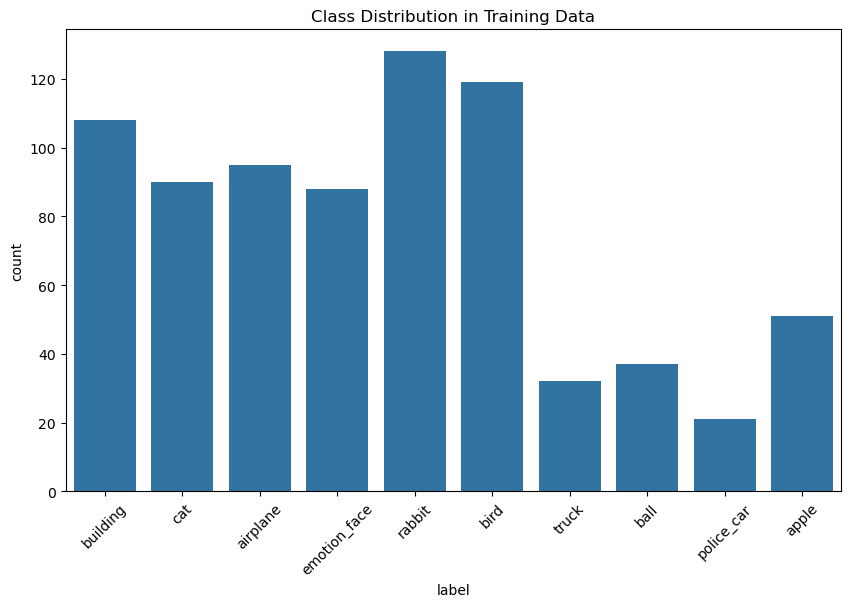

In [6]:
# 데이터 시각화
plt.figure(figsize=(10, 6))
sns.countplot(x=train_df['label'])
plt.xticks(rotation=45)
plt.title("Class Distribution in Training Data")
plt.show()

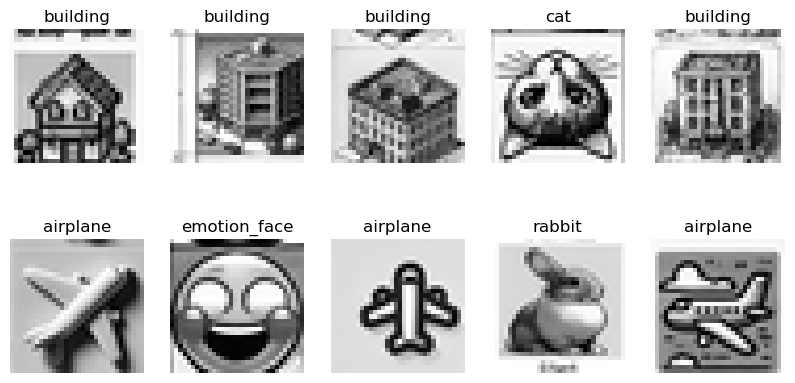

In [7]:
# 샘플 이미지 확인
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axes.flat):
    img = train_features[i].reshape(32, 32)
    ax.imshow(img, cmap='gray')
    ax.set_title(label_encoder.inverse_transform([train_labels[i]])[0])
    ax.axis('off')
plt.show()

In [8]:
# 데이터 분할
X_train, X_val, y_train, y_val = train_test_split(train_features, train_labels, test_size=0.2, random_state=42)

# 데이터셋 및 데이터로더 생성
train_dataset = ImageDataset(X_train, y_train)
val_dataset = ImageDataset(X_val, y_val)
test_dataset = ImageDataset(test_features)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [9]:
# 모델 학습
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ResNet 모델
resnet_model = ResNetModel().to(device)
resnet_criterion = nn.CrossEntropyLoss()
resnet_optimizer = optim.AdamW(resnet_model.parameters(), lr=0.001, weight_decay=1e-4)
resnet_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(resnet_optimizer, mode='min', patience=5, factor=0.5)

# MLP 모델
mlp_model = MLPModel().to(device)
mlp_criterion = nn.CrossEntropyLoss()
mlp_optimizer = optim.AdamW(mlp_model.parameters(), lr=0.001, weight_decay=1e-4)
mlp_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(mlp_optimizer, mode='min', patience=5, factor=0.5)

num_epochs = 15
resnet_train_losses, resnet_val_losses, resnet_val_accuracies = [], [], []
mlp_train_losses, mlp_val_losses, mlp_val_accuracies = [], [], []

for epoch in range(num_epochs):
    # ResNet 학습
    resnet_model.train()
    resnet_total_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        resnet_optimizer.zero_grad()
        outputs = resnet_model(X_batch)
        loss = resnet_criterion(outputs, y_batch)
        loss.backward()
        resnet_optimizer.step()
        resnet_total_loss += loss.item()
    resnet_train_losses.append(resnet_total_loss / len(train_loader))
    
    # ResNet 검증
    resnet_model.eval()
    resnet_val_loss, resnet_correct, resnet_total = 0, 0, 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = resnet_model(X_batch)
            loss = resnet_criterion(outputs, y_batch)
            resnet_val_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            resnet_correct += (preds == y_batch).sum().item()
            resnet_total += y_batch.size(0)
    resnet_val_losses.append(resnet_val_loss / len(val_loader))
    resnet_val_accuracy = resnet_correct / resnet_total
    resnet_val_accuracies.append(resnet_val_accuracy)
    resnet_scheduler.step(resnet_val_loss)
    
    # MLP 학습
    mlp_model.train()
    mlp_total_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        mlp_optimizer.zero_grad()
        outputs = mlp_model(X_batch.squeeze(1))  # MLP는 1채널 이미지를 flatten해야 함
        loss = mlp_criterion(outputs, y_batch)
        loss.backward()
        mlp_optimizer.step()
        mlp_total_loss += loss.item()
    mlp_train_losses.append(mlp_total_loss / len(train_loader))
    
    # MLP 검증
    mlp_model.eval()
    mlp_val_loss, mlp_correct, mlp_total = 0, 0, 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = mlp_model(X_batch.squeeze(1))  # MLP는 1채널 이미지를 flatten해야 함
            loss = mlp_criterion(outputs, y_batch)
            mlp_val_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            mlp_correct += (preds == y_batch).sum().item()
            mlp_total += y_batch.size(0)
    mlp_val_losses.append(mlp_val_loss / len(val_loader))
    mlp_val_accuracy = mlp_correct / mlp_total
    mlp_val_accuracies.append(mlp_val_accuracy)
    mlp_scheduler.step(mlp_val_loss)
    
    print(f"Epoch {epoch+1}/{num_epochs},")
    print(f"ResNet: Train Loss: {resnet_train_losses[-1]:.4f}, Val Loss: {resnet_val_losses[-1]:.4f}, Val Accuracy: {resnet_val_accuracy:.4f}")
    print(f"MLP: Train Loss: {mlp_train_losses[-1]:.4f}, Val Loss: {mlp_val_losses[-1]:.4f}, Val Accuracy: {mlp_val_accuracy:.4f}")

c:\Users\09048\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\09048\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1/15,
ResNet: Train Loss: 1.2576, Val Loss: 9.2025, Val Accuracy: 0.1429
MLP: Train Loss: 2.1925, Val Loss: 2.1082, Val Accuracy: 0.1494
Epoch 2/15,
ResNet: Train Loss: 0.3862, Val Loss: 3.7500, Val Accuracy: 0.2013
MLP: Train Loss: 2.0829, Val Loss: 2.0024, Val Accuracy: 0.3766
Epoch 3/15,
ResNet: Train Loss: 0.2313, Val Loss: 1.8256, Val Accuracy: 0.4351
MLP: Train Loss: 1.9352, Val Loss: 1.8054, Val Accuracy: 0.4221
Epoch 4/15,
ResNet: Train Loss: 0.1695, Val Loss: 0.6205, Val Accuracy: 0.8442
MLP: Train Loss: 1.7284, Val Loss: 1.6491, Val Accuracy: 0.3961
Epoch 5/15,
ResNet: Train Loss: 0.2408, Val Loss: 0.6549, Val Accuracy: 0.7987
MLP: Train Loss: 1.5853, Val Loss: 1.4999, Val Accuracy: 0.5390
Epoch 6/15,
ResNet: Train Loss: 0.2271, Val Loss: 0.4907, Val Accuracy: 0.8182
MLP: Train Loss: 1.4170, Val Loss: 1.4281, Val Accuracy: 0.4935
Epoch 7/15,
ResNet: Train Loss: 0.1486, Val Loss: 0.9087, Val Accuracy: 0.8052
MLP: Train Loss: 1.3141, Val Loss: 1.3172, Val Accuracy: 0.5130

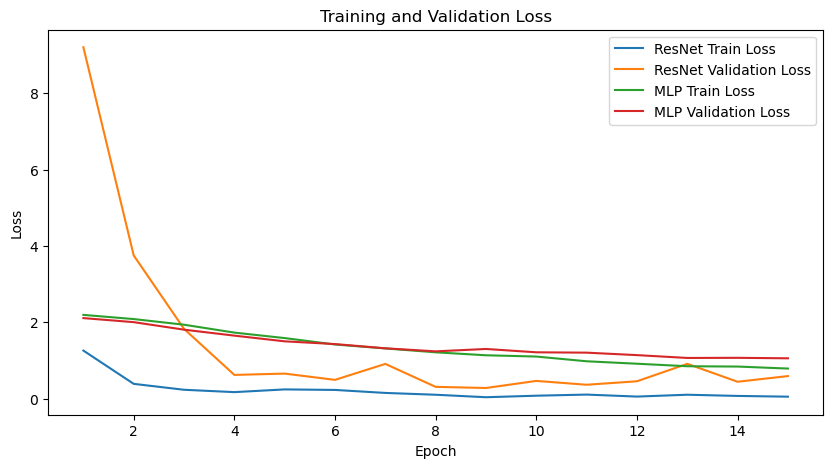

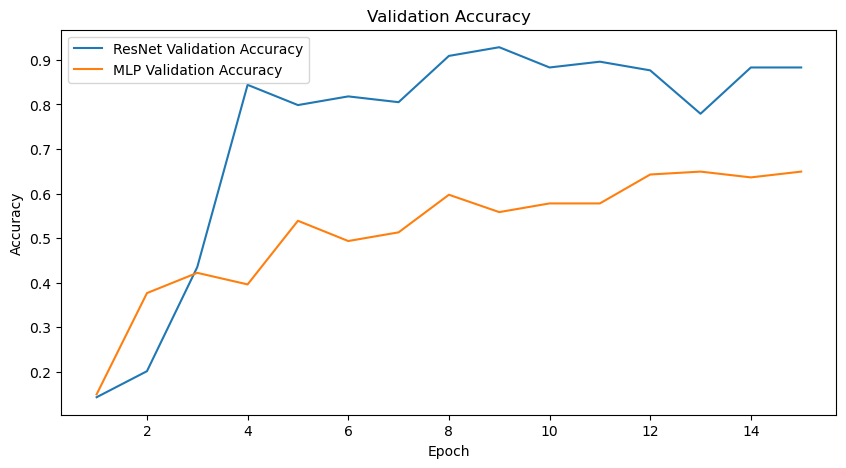

In [10]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), resnet_train_losses, label='ResNet Train Loss')
plt.plot(range(1, num_epochs + 1), resnet_val_losses, label='ResNet Validation Loss')
plt.plot(range(1, num_epochs + 1), mlp_train_losses, label='MLP Train Loss')
plt.plot(range(1, num_epochs + 1), mlp_val_losses, label='MLP Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), resnet_val_accuracies, label='ResNet Validation Accuracy')
plt.plot(range(1, num_epochs + 1), mlp_val_accuracies, label='MLP Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Validation Accuracy')
plt.show()

In [11]:
# 앙상블 예측
resnet_model.eval()
mlp_model.eval()
predictions = []
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        resnet_outputs = resnet_model(X_batch)
        mlp_outputs = mlp_model(X_batch.squeeze(1))  # MLP는 1채널 이미지를 flatten해야 함
        
        # 두 모델의 출력을 평균내어 앙상블
        ensemble_outputs = (resnet_outputs + mlp_outputs) / 2
        
        preds = torch.argmax(ensemble_outputs, dim=1).cpu().numpy()
        predictions.extend(preds)

In [12]:
# 결과 저장
submission = pd.DataFrame({"ID": test_df["ID"], "label": label_encoder.inverse_transform(predictions)})
submission.to_csv("submission.csv", index=False)